In [20]:
import numpy as np
import cvxpy as cp
import scipy as sp
from pyquaternion import Quaternion
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import Image

## Simulation Parameters

In [43]:
dt = 0.04  # timestep
t = 3  # duration
m = 1  # mass
r = 1  # radius of ball
J = 0.4 * m * r**2 * np.eye(3)  # inertia matrix
J_inv = np.linalg.inv(J)
q0 = np.array([0, 0, 1, 1, 0, 0, 0])  # init pos/quat with scalar part first
q1_quat = np.array([0.999, 0, 0.035, 0])
q1 = np.array([0, .01, 1] + (q1_quat/np.linalg.norm(q1_quat)).tolist())  # init vel
q0, q1 = q1, q0
force = np.array([0, 0.1, 0])  # init force
torque = np.array([0, 2, 0])
g = 9.8  # gravitational acceleration
# mu = 0.05  # coefficient of friction of the plane
n = np.array([0, 0, 1])  # phi(q) = n @ q

In [3]:
# helpers
def quat(q):
    return Quaternion(q[3:])

def pos(q):
    return q[:3]

## Simulation Backend

In [4]:
class SimSystemState:
    def __init__(self, q0, q1):
        self.q_last = q0
        self.q = q1
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]
        

In [16]:
class Block2DRot(SimSystemState):
    def __init__(self, last_state, state, mass, force, torque,
                 dt=0.1):
        super().__init__(last_state, state)
        self.m = mass
        self.dt = dt
        self.force = force
        self.torque = torque
        self.w = 2/self.dt * (quat(self.q).conjugate * quat(self.q_last)).vector
    
    def step_q(self, update=True):
        pos_new = self.force / m * self.dt**2 + 2*pos(self.q) - pos(self.q_last)
        w_new = self.w + self.dt * J_inv @ (torque - np.cross(self.w, J @ self.w))
        quat_new = (Quaternion.exp(Quaternion(scalar=0, vector=w_new*self.dt/2)) * quat(self.q).inverse)\
                    .conjugate.unit.elements
        q_new = np.concatenate((pos_new, quat_new))
        if update:
            self.q_last = self.q
            self.q = q_new
            self.w = w_new
        return q_new
    
    def plot(self, q=None):
        if q is None:
            q = self.q
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [17]:
def sim(system, time=10):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param timesteps: (int) number of timesteps to simulate for
    """
    qs = [system.q.copy()]
    t = 0
    while t < time:
        qs.append(system.step_q().copy())
        t += system.dt
    return np.stack(qs)

In [44]:
system = Block2DRot(q0, q1, m, force, torque, dt)
qs = sim(system, time=t)

In [ ]:
qs

## Plot

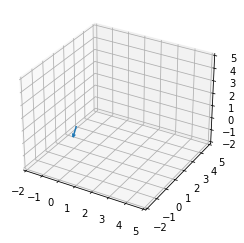

In [45]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
filename = 'rot_ball.gif'

def get_arrow(t):
    q = qs[t]
    x, y, z = pos(q)
    u, v, w = quat(q).rotate(np.array([0., 0., 1.]))
    return x, y, z, u, v, w

quiver = ax.quiver(*get_arrow(0))

ax.set_xlim(-2, 5)
ax.set_ylim(-2, 5)
ax.set_zlim(-2, 5)

def update(t):
    global quiver
    quiver.remove()
    quiver = ax.quiver(*get_arrow(t))

ani = FuncAnimation(fig, update, frames=range(len(qs)), interval=1000*dt)
ani.save(filename)

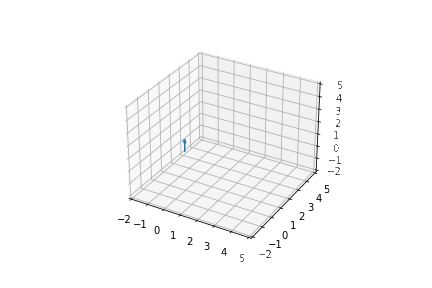

In [46]:
Image(filename=filename)